 # Лабораторная работа 3. Обучение без учителя

Результат лабораторной работы - отчет в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

## Кластеризация

![Digits](https://i.imgur.com/DINSGXS.png)

Задача [кластеризации](https://en.wikipedia.org/wiki/Cluster_analysis) данных является одним из примеров задач обучения "без учителя". Она заключается в разбиении множества объектов на кластеры, при этом предполагается, что внутри одного кластера будут находиться похожие между собой объекты. Одним из примеров методов кластеризации является алгоритм [KMeans](https://en.wikipedia.org/wiki/K-means_clustering).

### Выбор числа кластеров

Для некоторых алгоритмов кластеризации число кластеров является гиперпараметром (например, в случае KMeans). Поэтому для выбора количества кластеров может быть использован следующий подход: при фиксированной метрике качества для разного числа кластеров вычисляется кластеризация и выбирается то количество кластеров, начиная с которого качество "стабилизируется".

### Метрики качества

Оценивание качества построенной кластеризации не всегда тривиальная задача, так как следует учитывать такие факты как:
 - объекты одного кластера должны быть более похожи, чем объекты других кластеров, относительно некоторой заданной метрики похожести
 - метрика не должна учитывать абсолютные значения меток объектов, попавших в кластер (в случае, если истинные метки известны)

При выполнении задания для оценки качества получившейся кластеризации воспользуемся следующими метриками:
 - [Homogeneity и Completeness](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure) 
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) 
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

Загрузите набор данных [digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Перед применением алгоритмов не забудьте перемешать изображения.

In [208]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tqdm import tqdm_notebook as tqdm

from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score, silhouette_score, precision_score, recall_score
from sklearn.datasets import load_digits, load_wine
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelSpreading
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [124]:
digits = load_digits()

indices = np.arange(len(digits.data))
np.random.shuffle(indices)

X = digits.data[indices]
y = digits.target[indices]

**Задание 1. (1 балл)** Кластеризуйте изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html): 
* Подберите число кластеров для некоторой фиксированной метрики из указанных выше. 
* Рассмотрите различные способы выбора начального приближения (параметр *init*). 
* Оцените качество получившейся кластеризации используя все описанные выше метрики. 
* Визуализируйте изображения, соответствующие центроидам лучшей кластеризации. 
* Визуализируйте несколько изображений, которые во всех случаях были отнесены к неправильному кластеру (объект назовем ошибочно отнесенным, если он имеет иную метку класса, нежели большая часть объектов в кластере). Можете ли вы пояснить, почему так произошло?

In [150]:
def get_scores(clusterer, X, y):
    y_pred = clusterer.fit_predict(X, y)
    result = {
        'homogeneity_score': homogeneity_score(y, y_pred),
        'completeness_score': completeness_score(y, y_pred),
        'adjusted_rand_score': adjusted_rand_score(y, y_pred),
        'silhouette_score': silhouette_score(X, y_pred)
    }
    if 'n_iter_' in dir(clusterer):
        result['converged_after'] = clusterer.n_iter_
    return result

def print_score(score_name, scores, reference=None):
    if score_name not in scores:
        return
    ref = (scores[score_name]/reference[score_name] - 1)*100 if reference else 0
    ref = f'+{ref:05.2f}' if ref >= 0 else f'{ref:06.2f}'
    print(f'{score_name}:\t{scores[score_name]:.4f}' + (f'\t({ref}%)' if reference else ''))
    
def print_scores(clusterer, X, y, reference=None):
    scores = get_scores(clusterer, X, y)
    print_score('converged_after', scores, reference)
    print_score('homogeneity_score', scores, reference)
    print_score('completeness_score', scores, reference)
    print_score('adjusted_rand_score', scores, reference)
    print_score('silhouette_score', scores, reference)

In [126]:
reference = get_scores(KMeans(n_clusters=10, random_state=42), X, y)
for i in range(7, 14):
    print(f'n_clusters={i}')
    print_scores(KMeans(n_clusters=i, random_state=42), X, y, reference)
    print()

n_clusters=7
converged_after:	13.0000	(-31.58%)
homogeneity_score:	0.5660	(-23.47%)
completeness_score:	0.6909	(-07.62%)
adjusted_rand_score:	0.4686	(-30.07%)
silhouette_score:	0.1587	(-13.00%)

n_clusters=8
converged_after:	8.0000	(-57.89%)
homogeneity_score:	0.6607	(-10.67%)
completeness_score:	0.7545	(+00.88%)
adjusted_rand_score:	0.5711	(-14.77%)
silhouette_score:	0.1784	(-02.21%)

n_clusters=9
converged_after:	13.0000	(-31.58%)
homogeneity_score:	0.6888	(-06.87%)
completeness_score:	0.7463	(-00.22%)
adjusted_rand_score:	0.5941	(-11.34%)
silhouette_score:	0.1891	(+03.65%)

n_clusters=10
converged_after:	19.0000	(+00.00%)
homogeneity_score:	0.7396	(+00.00%)
completeness_score:	0.7479	(+00.00%)
adjusted_rand_score:	0.6701	(+00.00%)
silhouette_score:	0.1824	(+00.00%)

n_clusters=11
converged_after:	13.0000	(-31.58%)
homogeneity_score:	0.7916	(+07.03%)
completeness_score:	0.7660	(+02.42%)
adjusted_rand_score:	0.7249	(+08.19%)
silhouette_score:	0.1842	(+01.00%)

n_clusters=12
converged_

Выше мы вывели все метрики для различного числа кластеров. Чтобы было нагляднее, в скобках приведено увеличение/уменьшение метрики в сравнении с `KMeans(n_clusters=10)`, который на первый взгляд кажется логичнее всего здесь использовать. Однако, все метрики увеличиваются, если взять 11 кластеров, что можно объяснить возможностью отнести к дополнительному классу неразборчиво написанные цифры или цифры, в принадлежности которых к конкретному классу у алгоритма нет уверенности.

In [127]:
print_scores(KMeans(n_clusters=11, init=np.zeros((11, 64)), n_init=1, random_state=42), X, y)

converged_after:	22.0000
homogeneity_score:	0.7105
completeness_score:	0.7204
adjusted_rand_score:	0.5525
silhouette_score:	0.1845


In [128]:
print_scores(KMeans(n_clusters=11, init='k-means++', random_state=42), X, y)

converged_after:	13.0000
homogeneity_score:	0.7916
completeness_score:	0.7660
adjusted_rand_score:	0.7249
silhouette_score:	0.1842


In [129]:
print_scores(KMeans(n_clusters=11, init='random', random_state=42), X, y)

converged_after:	19.0000
homogeneity_score:	0.7838
completeness_score:	0.7594
adjusted_rand_score:	0.7235
silhouette_score:	0.1829


Рассмотрел 3 способа инициализации весов: инициализация нулями, рандомная инициализация и `k-means++`, который должен инициализировать как-то по-умному. В результате инициализация нулями ожидаемо показала худший результат, `k-means++` и `random` получили сравнимые значения, однако инициализация `k-means++` все же оказалась немного лучше.

In [130]:
kmeans = KMeans(n_clusters=11, init='k-means++', random_state=42)
y_pred = kmeans.fit_predict(X, y)

d = defaultdict(lambda: Counter())
for y_, y_pred_ in zip(y, y_pred):
    d[y_pred_][y_] += 1
d

defaultdict(<function __main__.<lambda>>,
            {0: Counter({0: 177, 2: 1, 6: 1}),
             1: Counter({2: 1, 3: 7, 4: 7, 7: 170, 8: 1, 9: 7}),
             2: Counter({1: 1, 2: 9, 3: 157, 5: 1, 8: 1, 9: 3}),
             3: Counter({1: 2, 5: 2, 6: 177, 8: 1}),
             4: Counter({1: 100, 3: 3, 4: 4, 6: 2, 7: 9, 8: 40, 9: 1}),
             5: Counter({1: 1, 3: 2, 5: 138, 8: 6, 9: 6}),
             6: Counter({2: 1, 3: 6, 5: 39, 8: 3, 9: 142}),
             7: Counter({0: 1, 4: 166, 5: 2}),
             8: Counter({1: 54, 2: 1, 4: 3, 6: 1, 8: 3, 9: 20}),
             9: Counter({1: 24, 2: 145, 8: 2}),
             10: Counter({2: 19, 3: 8, 4: 1, 8: 117, 9: 1})})

In [131]:
mapping = {x: d[x].most_common(1)[0] for x in d}
mapping

{0: (0, 177),
 1: (7, 170),
 2: (3, 157),
 3: (6, 177),
 4: (1, 100),
 5: (5, 138),
 6: (9, 142),
 7: (4, 166),
 8: (1, 54),
 9: (2, 145),
 10: (8, 117)}

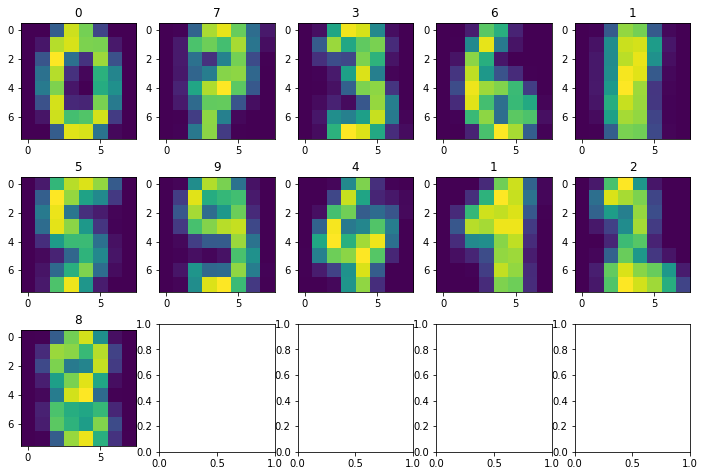

In [132]:
centers = kmeans.cluster_centers_
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for im, ax, i in zip(centers, axes.flatten(), range(11)):
    ax.imshow(im.reshape((8, 8)))
    ax.set_title(mapping[i][0])

Видно, что в 8 классе алгоритм не сильно уверен. Алгоритм относит туда в основном единицы (которые видимо не очень похожи на нормальные единицы), но также там получилось много девяток. На центре кластера для этого класса изображена единица, но ее также можно принять за четверку.

Так как классов мы взяли больше, чем у нас цифр, у нас есть целый класс с ошибочными предсказаниями, посмотрим сначала на все остальные классы:

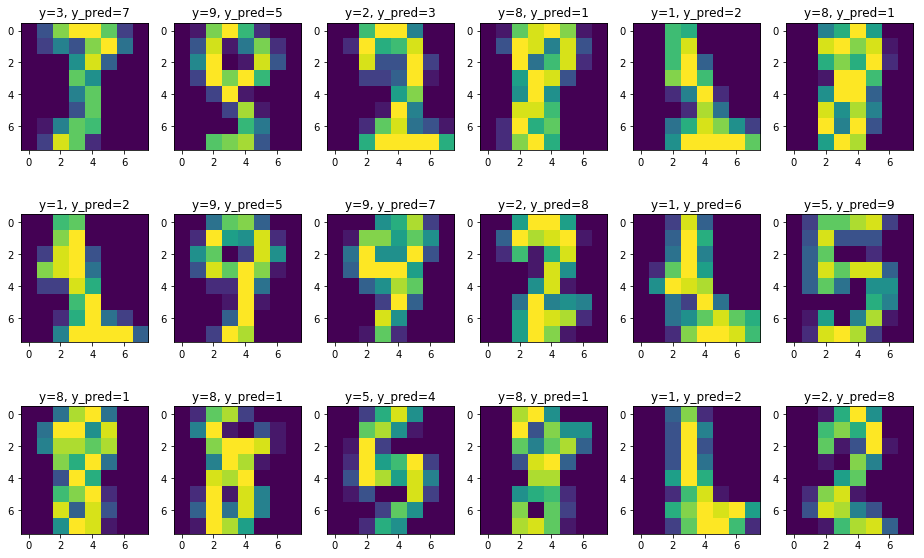

In [139]:
y_labels = np.array([mapping[i][0] for i in y_pred])
errors = np.array([y_pred[i] != 8 and mapping[y_pred[i]][0] != y[i] for i in range(len(y_pred))])
fig, axes = plt.subplots(3, 6, figsize=(16, 10))
for X_, y_, y_label, ax in zip(X[errors], y[errors], y_labels[errors], axes.flatten()):
    ax.imshow(X_.reshape((8, 8)))
    ax.set_title(f'y={y_}, y_pred={y_label}')

Теперь посмотрим, что наш алгоритм отнес к 11 классу

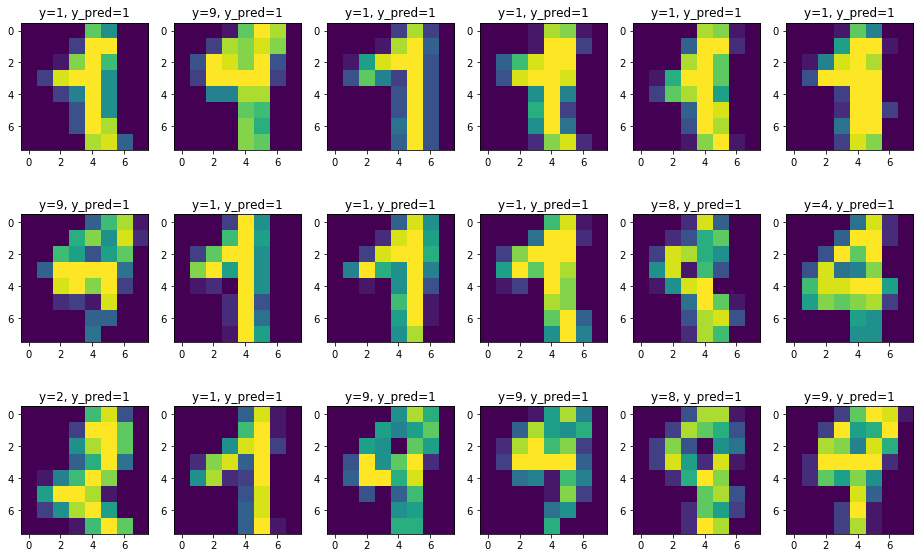

In [140]:
errors = np.array([y_pred[i] == 8 for i in range(len(y_pred))])
fig, axes = plt.subplots(3, 6, figsize=(16, 10))
for X_, y_, y_label, ax in zip(X[errors], y[errors], y_labels[errors], axes.flatten()):
    ax.imshow(X_.reshape((8, 8)))
    ax.set_title(f'y={y_}, y_pred={y_label}')

Видимо, к классу с единицами отнесены в основном единицы "палочки", а к одиннадцатому классу - в основном единицы с "козырьком"

Видно, что некоторые из приведенных выше изображений даже человеку бывает сложно отнести к тому или иному классу, поэтому алгоритм тоже на них ошибается

Не всегда бывает удобно работать с полной матрицей объект-признак, например, для случая визуализации данных. [Здесь](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py) показано сравнение различных способов сжатия размерности для проекции на плоскость. На изображениях видно, что некоторые преобразования дают неплохую картину и похожие объекты расположены близко друг к другу. Посмотрим, поможет ли это на практике.
 
**Задание 2. (2 балла)** Примените преобразования [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (для числа компонент 2), после чего подайте полученные представления объектов на вход алгоритмам KMeans, [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) и [Birch](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html). 
* Сравните новые и предыдущие результаты. 
* Нашлась ли пара "представление"—"алгоритм", превосходящая другие по всем метрикам? 
* Являются ли все три метрики согласованными? Можете ли вы объяснить почему?

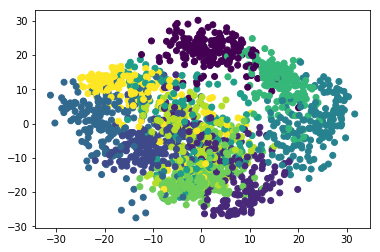

In [143]:
pca = PCA(n_components=2).fit_transform(X)
plt.scatter(pca[:, 0], pca[:, 1], c=y)

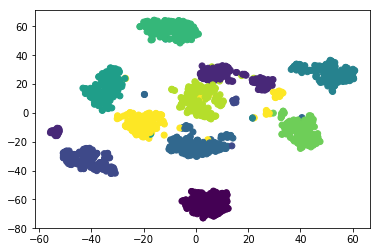

In [144]:
tsne = TSNE(n_components=2).fit_transform(X)
plt.scatter(tsne[:, 0], tsne[:, 1], c=y)

In [163]:
reference_pca = get_scores(KMeans(n_clusters=10, random_state=42), pca, y)
reference_tsne = get_scores(KMeans(n_clusters=10, random_state=42), tsne, y)
for i in range(8, 13):
    print(f'n_clusters={i}, X=pca')
    print_scores(KMeans(n_clusters=i, init='k-means++', random_state=42), pca, y, reference_pca)
    print(f'n_clusters={i}, X=tsne')
    print_scores(KMeans(n_clusters=i, init='k-means++', random_state=42), tsne, y, reference_tsne)
    print()

n_clusters=8, X=pca
converged_after:	19.0000	(+26.67%)
homogeneity_score:	0.4832	(-07.88%)
completeness_score:	0.5398	(+02.21%)
adjusted_rand_score:	0.3711	(-06.18%)
silhouette_score:	0.3967	(+00.73%)
n_clusters=8, X=tsne
converged_after:	11.0000	(+175.00%)
homogeneity_score:	0.7833	(-14.93%)
completeness_score:	0.8819	(-04.34%)
adjusted_rand_score:	0.7145	(-20.66%)
silhouette_score:	0.6142	(-03.50%)

n_clusters=9, X=pca
converged_after:	11.0000	(-26.67%)
homogeneity_score:	0.5085	(-03.07%)
completeness_score:	0.5381	(+01.89%)
adjusted_rand_score:	0.3883	(-01.83%)
silhouette_score:	0.4048	(+02.80%)
n_clusters=9, X=tsne
converged_after:	4.0000	(+00.00%)
homogeneity_score:	0.8498	(-07.70%)
completeness_score:	0.8997	(-02.40%)
adjusted_rand_score:	0.8051	(-10.60%)
silhouette_score:	0.6240	(-01.97%)

n_clusters=10, X=pca
converged_after:	15.0000	(+00.00%)
homogeneity_score:	0.5245	(+00.00%)
completeness_score:	0.5282	(+00.00%)
adjusted_rand_score:	0.3955	(+00.00%)
silhouette_score:	0.3938	

И для PCA и для TSNE скоры KMeans не улучшились при увеличении количества кластеров с 10 до 11

In [166]:
print_scores(KMeans(n_clusters=10, init='k-means++', random_state=42), pca, y)

converged_after:	15.0000
homogeneity_score:	0.5245
completeness_score:	0.5282
adjusted_rand_score:	0.3955
silhouette_score:	0.3938


In [167]:
print_scores(KMeans(n_clusters=10, init='k-means++', random_state=42), tsne, y)

converged_after:	4.0000
homogeneity_score:	0.9207
completeness_score:	0.9218
adjusted_rand_score:	0.9005
silhouette_score:	0.6365


In [172]:
reference_pca = get_scores(DBSCAN(min_samples=3), pca, y)
reference_tsne = get_scores(DBSCAN(min_samples=3), tsne, y)
for eps in [0.5, 1, 1.5, 2, 2.5, 3, 3.5]:
    print(f'eps={eps}, X=pca')
    print_scores(DBSCAN(min_samples=3, eps=eps), pca, y, reference_pca)
    print(f'eps={eps}, X=tsne')
    print_scores(DBSCAN(min_samples=3, eps=eps), tsne, y, reference_tsne)
    print()

eps=0.5, X=pca
homogeneity_score:	0.2116	(+00.00%)
completeness_score:	0.2579	(+00.00%)
adjusted_rand_score:	0.0020	(+00.00%)
silhouette_score:	-0.4625	(+00.00%)
eps=0.5, X=tsne
homogeneity_score:	0.1206	(+00.00%)
completeness_score:	0.3156	(+00.00%)
adjusted_rand_score:	0.0006	(+00.00%)
silhouette_score:	-0.7044	(+00.00%)

eps=1, X=pca
homogeneity_score:	0.4916	(+132.36%)
completeness_score:	0.3461	(+34.17%)
adjusted_rand_score:	0.1367	(+6756.99%)
silhouette_score:	-0.1700	(-63.24%)
eps=1, X=tsne
homogeneity_score:	0.7400	(+513.53%)
completeness_score:	0.3891	(+23.30%)
adjusted_rand_score:	0.0436	(+7416.49%)
silhouette_score:	0.0882	(-112.52%)

eps=1.5, X=pca
homogeneity_score:	0.2797	(+32.23%)
completeness_score:	0.5368	(+108.11%)
adjusted_rand_score:	0.1296	(+6398.16%)
silhouette_score:	-0.4142	(-10.44%)
eps=1.5, X=tsne
homogeneity_score:	0.9523	(+689.53%)
completeness_score:	0.6466	(+104.89%)
adjusted_rand_score:	0.5994	(+103234.47%)
silhouette_score:	0.0616	(-108.74%)

eps=2, X=pc

Видно, что если тюнить параметр `eps` у DBSCAN, можно получить очень большой прирост качества, но по всем метрикам KMeans побить не удалось

In [173]:
print_scores(DBSCAN(min_samples=3, eps=3.5), pca, y)

homogeneity_score:	0.0012
completeness_score:	0.2236
adjusted_rand_score:	-0.0000
silhouette_score:	0.2090


In [174]:
print_scores(DBSCAN(min_samples=3, eps=3.5), tsne, y)

homogeneity_score:	0.9264
completeness_score:	0.8787
adjusted_rand_score:	0.8459
silhouette_score:	0.4903


In [175]:
reference_pca = get_scores(Birch(n_clusters=10), pca, y)
reference_tsne = get_scores(Birch(n_clusters=10), tsne, y)
for i in range(8, 13):
    print(f'n_clusters={i}, X=pca')
    print_scores(Birch(n_clusters=i), pca, y, reference_pca)
    print(f'n_clusters={i}, X=tsne')
    print_scores(Birch(n_clusters=i), tsne, y, reference_tsne)
    print()

n_clusters=8, X=pca
homogeneity_score:	0.4560	(-07.85%)
completeness_score:	0.5332	(+04.11%)
adjusted_rand_score:	0.3302	(-06.49%)
silhouette_score:	0.3516	(+09.59%)
n_clusters=8, X=tsne
homogeneity_score:	0.8154	(-11.43%)
completeness_score:	0.9226	(+00.09%)
adjusted_rand_score:	0.7457	(-17.19%)
silhouette_score:	0.6160	(-03.11%)

n_clusters=9, X=pca
homogeneity_score:	0.4714	(-04.74%)
completeness_score:	0.5069	(-01.03%)
adjusted_rand_score:	0.3462	(-01.97%)
silhouette_score:	0.3433	(+07.02%)
n_clusters=9, X=tsne
homogeneity_score:	0.8660	(-05.93%)
completeness_score:	0.9233	(+00.17%)
adjusted_rand_score:	0.8093	(-10.14%)
silhouette_score:	0.6251	(-01.68%)

n_clusters=10, X=pca
homogeneity_score:	0.4949	(+00.00%)
completeness_score:	0.5122	(+00.00%)
adjusted_rand_score:	0.3531	(+00.00%)
silhouette_score:	0.3208	(+00.00%)
n_clusters=10, X=tsne
homogeneity_score:	0.9206	(+00.00%)
completeness_score:	0.9217	(+00.00%)
adjusted_rand_score:	0.9006	(+00.00%)
silhouette_score:	0.6357	(+00.00

In [176]:
print_scores(Birch(n_clusters=10), pca, y)

homogeneity_score:	0.4949
completeness_score:	0.5122
adjusted_rand_score:	0.3531
silhouette_score:	0.3208


In [177]:
print_scores(Birch(n_clusters=10), tsne, y)

homogeneity_score:	0.9206
completeness_score:	0.9217
adjusted_rand_score:	0.9006
silhouette_score:	0.6357


В итоге лучшие результаты получились у KMeans и Birch с `n_clusters=10`

## Частичное обучение

![](https://i.imgur.com/C6HjiXq.png)

Качество unsupervised методов можно существенно улучшить, зная правильные ответы хотя бы для небольшой части выборки. Методы такого рода называются _частичным обучением (semi-supervised learning)_. Более подробно про реализацию таких методов в sklearn можно прочитать в разделе [semi-supervised](http://scikit-learn.org/stable/modules/label_propagation.html#semi-supervised).

Загрузите датасет [Wine](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) и создайте из него выборку, где для каждого класса имеется по одному объекту с известным ответом, а ответы на остальных объектах равны -1. 

In [249]:
wine = load_wine()

indices = np.arange(len(wine.data))
np.random.shuffle(indices)

X = wine.data[indices]
y = wine.target[indices]

In [250]:
y_train = -1*np.ones(y.shape, dtype=np.int32)
for y_ in np.unique(y):
    y_train[np.where(y == y_)[0][0]] = y_

**Задание 3. (1 балл)** Обучите [LabelSpreading](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html) на этих данных, рассмотрев различные значения параметра **kernel** (*knn*, *rbf*). Посчитайте качество полученной разметки для каждого класса (в качестве метрик используйте точность и полноту). 

In [251]:
clf = LabelSpreading(kernel='knn')
clf.fit(X, y_train)
y_pred = clf.predict(X)
print('kernel=knn')
print('precision_score for classes: ', precision_score(y, y_pred, average=None))
print('recall_score for classes: ', recall_score(y, y_pred, average=None))

C:\anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


kernel=knn
precision_score for classes:  [0.45384615 0.79166667 0.54166667]
recall_score for classes:  [1.         0.26760563 0.27083333]


In [252]:
clf = LabelSpreading(kernel='rbf', gamma=0.001)
clf.fit(X, y_train)
y_pred = clf.predict(X)
print('kernel=rbf')
print('precision_score for classes: ', precision_score(y, y_pred, average=None))
print('recall_score for classes: ', recall_score(y, y_pred, average=None))

kernel=rbf
precision_score for classes:  [0.79452055 0.84313725 0.57407407]
recall_score for classes:  [0.98305085 0.6056338  0.64583333]


**Задание 4. (0.5 балла)** Попробуйте запустить алгоритм несколько раз, отмечая известными различные объекты, посчитайте качество и визуализируйте результаты. Можно ли сказать, что алгоритм сильно зависит от известных начальных объектов? Есть ли класс, для которого это больше всего заметно?

**Указание.** Для визуализации результатов отобразите объекты вместе с верными и предсказанными ответами на двумерном графике, использовав [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) с 2 компонентами.

## Тематическое моделирование

![](http://imgur.com/S8WgwBp.png)

Тематическое моделирование является популярным инструментом анализа текстов. Задача заключается в поиске тем $T$, которые хорошо бы описывали документы $D$ со словарём $W$. Большинство тематических моделей оперирует данными в формате "мешка слов", т.е. учитывают только частоты слов в документах, а не их порядок. Одной из простейших тематических моделей является [PLSA](https://en.wikipedia.org/wiki/Probabilistic_latent_semantic_analysis), которая приводит к задаче стохастического матричного разложения: 

$$F \approx \Phi \times \Theta$$
где
- $F_{W \times D}$— матрица распределений слов в документах (нормированные частоты)
- $\Phi_{W \times T}$ — матрица распределений слов в темах (модель)
- $\Theta_{T \times D}$ — матрица распределений тем в документах (результат применения модели к обучающим данным)

Можно сказать, что алгоритмы тематического моделирования производят мягкую бикластеризацию данных:
 - *мягкую*, так как объекты относятся не строго к одному кластеру, а к нескольким с разными вероятностями
 - *бикластеризацию*, так как модель одновременно кластеризует слова по темам и темы по документам.

### EM-алгоритм

![](http://imgur.com/EeIuI1T.png)

С вероятностной точки зрения, задача обучения модели PLSA ставится как максимизация неполного правдоподобия по параметам $\Phi$ и $\Theta$. ЕМ-алгоритм для модели PLSA заключается в повторении двух шагов:

- **Е-шаг** — оценка распределений тем для каждого слова в каждом документе по параметрам $\Phi$ и $\Theta$ (шаг 6);
- **М-шаг** — обновление параметров $\Phi$ и $\Theta$ на основе полученных оценок (шаги 7 и 9).

Существуют различные модификации итерационного процесса, позволяющие снизить расходы по памяти. В данном случае, мы избежим хранения трехмерной матрицы $p_{tdw}$, сразу пересчитывая $\Theta$ для текущего документа и аккумулируя счетчики $n_{wt}$ для последующего пересчета $\Phi$.

Псевдокод алгоритма записывается следующим образом:

1. Инициализировать $\phi_{wt}^0$ для всех $w \in W$, $t \in T$ и $\theta_{td}^0$ для всех $t \in T$, $d \in D$
2. Внешний цикл по итерациям $i = 1 ... max\_iter$:
3. $\quad$ $n_{wt}^i := 0$, $n_t^i := 0$ для всех $w \in W$ и $t \in T$ 
4. $\quad$ Внутренний цикл по документам $d \in D$  
5. $\qquad$ $Z_w := \sum_{t \in T} \phi_{wt}^{i-1}\theta_{td}^{i-1}$ для всех $w \in d$ $\cfrac{}{}$
6. $\qquad$ $p_{tdw} := \cfrac{ \phi_{wt}^{i-1}\theta_{td}^{i-1} }{ Z_w }$ (**E-шаг**)
7. $\qquad$ $\theta_{td}^{i} := \cfrac{ \sum_{w \in d} n_{dw} p_{tdw} }{ n_d }$ для всех $t \in T$ (**M-шаг**)
8. $\qquad$ Увеличить $n_{wt}^i$ и $n_t^i$ на $n_{dw} p_{tdw}$ для всех $w \in W$ и $t \in T$
9. $\quad \phi_{wt}^i := \cfrac{n_{wt}^i}{n_t^i}$ для всех $w \in W$ и $t \in T$ (**M-шаг**)

Обозначения:
 - $p_{tdw}$ — вероятность темы $t$ для слова $w$ в документе $d$
 - $\phi_{wt}$ — элемент матрицы $\Phi$, соответствующий вероятности слова $w$ в теме $t$
 - $\theta_{td}$ — элемент матрицы $\Theta$, соответствующий вероятности темы $t$ в документе $d$
 - $n_{wt}$ — элемент матрицы счётчиков отнесения слова $w$ к теме $t$ (путем нормирования этой матрицы получается матрица $\Phi$)
 - $Z_w$ — элемент вектора вспомогательных переменных, соответствующий слову $w$
 - $n_t$ — вектор нормировочных констант для матрицы $n_{wt}$
 - $n_d$ — вектор нормировочных констант для матрицы $n_{dw}$
 - $n$ — суммарное число слов в коллекции
 
###  Оценка качества

Для оценивания качества построенной модели и контроля сходимости процесса обучения обычно используют [перплексию](http://www.machinelearning.ru/wiki/images/8/88/Voron-iip9-talk.pdf):

$$\mathcal{P} = \exp\bigg(- \frac{\mathcal{L}}{n} \bigg) = \exp\bigg(- \cfrac{1}{n}\sum_{d \in D}\sum_{w \in d} n_{dw} \ln \big(\sum_{t \in T}\phi_{wt}\theta_{td} \big)\bigg)$$

Это традиционная мера качества в тематическом моделировании, которая основана на правдоподобии модели $\mathcal{L}$. Число итераций $max\_iter$ в алгоритме обучения следует выбирать достаточным для того, чтобы перплексия перестала существенно убывать. Однако известно, что перплексия плохо отражает интерпретируемость найденных тем, поэтому помимо нее обычно используются дополнительные меры или экспертные оценки.

### Рекомендации к реализации
- При делении на нулевые значения нужно просто заменить частное на ноль.
- ЕМ-алгоритм стоит реализовывать с использованием векторных операций. Для проверки корректности реализации сперва можно написать скалярную версию, после чего векторизовать её, удостоверившись, что обе реализации дают одинаковый результат. Невекторизованный алгоритм может работать в сотни раз медленнее векторизованного, и его использование может привести к невозможности выполнения задания.
- Итерационный процесс следует начинать, инициализировав матрицы $\Phi$ и $\Theta$. Инициализация может быть случайной, важно не забыть отнормировать столбцы матриц.
- Неэффективная реализация перплексии может в разы замедлить работу алгоритма.

Загрузите [коллекцию писем Х. Клинтон](https://yadi.sk/d/-Ci15wecokdxzQ) (коллекцию можно скачать прямо с сайта [kaggle.com](https://www.kaggle.com/kaggle/hillary-clinton-emails)). 

In [263]:
emails = pd.read_csv('Emails.csv')
emails.head(10)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
5,6,C05739559,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,Russorv@state.gov,H,80.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739559...,F-2015-04841,...,NaN,NaN,NaN,"Wednesday, September 12, 2012 01:00 PM",F-2015-04841,C05739559,05/13/2015,RELEASE IN PART,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
6,7,C05739560,"ANTI-MUSLIM FILM DIRECTOR IN HIDING, FOLLOWING...",H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739560...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>",NaN,"Wednesday, September 12, 2012 4:00 PM",F-2015-04841,C05739560,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
7,8,C05739561,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739561...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739561,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.corn>\nFriday, March 11...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
8,9,C05739562,SECRETARY'S REMARKS,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739562...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivanli@stategov>",NaN,"Wednesday, September 12, 2012 6:08 PM",F-2015-04841,C05739562,05/13/2015,RELEASE IN FULL,FYI,UNCLASSIFIED\nU.S. Department of State\nCase N...
9,10,C05739563,MORE ON LIBYA,H,NaN,NaN,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739563...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739563,05/13/2015,RELEASE IN PART,"B6\nWednesday, September 12, 2012 6:16 

In [254]:
emails.shape

(7945, 22)

Извлеките полные тексты писем из файла *Emails.csv* и подготовьте данные в формате "мешка слов" с помощью функции  [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) пакета sklearn. Рекомендуется произвести фильтрацию слов по частотности для удаления слишком редких и стоп-слов (рекомендованный нижний порог в пределах 10 и верхний 400-600).

In [255]:
table = str.maketrans({key: None for key in string.punctuation})
normalize = lambda x: x.lower().translate(table)

In [264]:
documents = emails.ExtractedBodyText.dropna().map(normalize)
documents.head()

1    b6\nthursday march 3 2011 945 pm\nh latest how...
2                                                  thx
4    h hrod17clintonemailcom\nfriday march 11 2011 ...
5    pis print\n•\nh  hrod17clintonernailcom\nwedne...
7    h hrod17clintonemailcorn\nfriday march 11 2011...
Name: ExtractedBodyText, dtype: object

In [265]:
c = Counter()
for document in documents:
    for word in document.split():
        c[word] += 1

In [266]:
def remove_rare_and_stopwords(document):
    new_document = ''
    for word in document.split():
        if 10 <= c[word] <= 500:
            new_document += word + ' '
    return new_document.strip()

In [267]:
documents = documents.map(remove_rare_and_stopwords)
documents.head()

1    b6 thursday march 3 2011 945 latest syria aidi...
2                                                  thx
4    hrod17clintonemailcom friday march 11 2011 hum...
5    pis print wednesday september 12 2012 fw meet ...
7    friday march 11 2011 huma abedin fw latest syr...
Name: ExtractedBodyText, dtype: object

In [268]:
c = Counter()
for document in documents:
    for word in document.split():
        c[word] += 1

In [269]:
[x for x in c.elements() if c[x] < 10], [x for x in c.elements() if c[x] > 500]

([], [])

In [270]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(documents)
vectors.shape

(6742, 5213)

**Задание 5. (3 балла)** Реализуйте описанный выше ЕМ-алгоритм для модели $PLSA$ и добавьте в вашу реализацию подсчёт перплексии. Примените ваш алгоритм к подготовленным данным, рассмотрев число тем T = 5. 
* Постройте график значения перплексии в зависимости от итерации (убедитесь в корректности реализации: график перплексии должен быть невозрастающим). 
* Выведите для каждой темы топ-20 наиболее вероятных слов. 

In [327]:
def dot_trace(a, b):
    result = 0
    for i in range(a.shape[0]):
        result += a[i, :].dot(b[:, i])
    return result

def perplexity(n_dw, Z):
    logZ = np.log(Z)
    logZ[np.isneginf(logZ)] = 0
    # n = n_dw.dot(n_dw.T).trace()
    return np.exp(-1/dot_trace(n_dw, n_dw.T)*dot_trace(n_dw, logZ))

In [328]:
def divide_by_zero(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

In [331]:
def train(T=5, max_iter=50):
    D, W = vectors.shape

    phi = np.random.rand(W, T)
    phi = phi/phi.sum(axis=0)

    theta = np.random.rand(T, D)
    theta = theta/theta.sum(axis=0)

    n_dw = vectors.toarray()
    n_d = vectors.sum(axis=1)

    perplexities = []
    for _ in tqdm(range(max_iter)):
        n_wt = np.zeros((W, T))
        Z = phi.dot(theta)
        for d in range(D):
            p_tdw = divide_by_zero((phi*theta[:, d]).T, Z[:, d])
            theta[:, d] = divide_by_zero((p_tdw*n_dw[d]).sum(axis=1), n_d[d][0,0])
            n_wt += (p_tdw*n_dw[d]).T
        phi = divide_by_zero(n_wt, n_wt.sum(axis=0))
        perplexities.append(perplexity(n_dw, phi.dot(theta)))
    
    plt.plot(perplexities)
    plt.xlabel('n_iter')
    plt.ylabel('perplexity')
    plt.show()
    
    return phi, theta

A Jupyter Widget

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


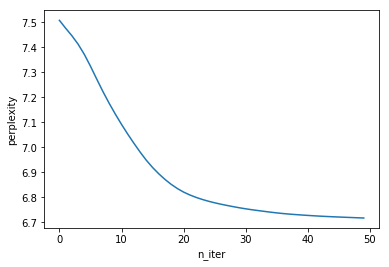

In [332]:
T = 5
phi, theta = train(T)

In [333]:
names = vectorizer.get_feature_names()
n = 20
for t in range(T):
    print(t, list(map(lambda i: names[i], np.argpartition(phi[:, t], -n)[-n:])))

0 ['cdm', 'friday', 'let', 'thx', 'mills', 'abedin', 'monday', 'print', 'pls', 'email', 'talk', 'sent', 'fw', 'huma', 're', 'b6', 'tomorrow', 'cheryl', 'ok', 'im']
1 ['fm', 'assistant', '845', 'floor', 'briefing', '830', 'minister', 'airport', 'washington', 'white', 'daily', 'route', 'arrive', 'conference', 'press', 'residence', 'depart', 'private', 'en', 'staff']
2 ['economic', 'development', 'public', 'even', 'between', 'global', 'years', 'many', 'war', 'afghan', 'china', 'international', 'israel', 'israeli', 'peace', 'women', 'administration', 'world', 'afghanistan', 'military']
3 ['statement', 'produced', '05132015', 'waiver', 'select', 'redactions', 'iran', 'doc', 'foia', 'comm', 'libya', 'f201504841', 'dept', 'case', 'benghazi', 'subject', 'agreement', 'sensitive', 'date', 'information']
4 ['campaign', 'against', 'even', 'voters', 'democrats', 'obamas', 'democratic', 'election', 'former', 'percent', 'republicans', 'party', 'health', 'care', 'republican', 'vote', 'white', 'says', 

**Задание 6. (1 балл)** Рассмотрите большее число тем (10, 20) и несколько различных начальных приближений. Проанализируйте результаты и ответьте на следующие вопросы: 
- Mожно ли сказать, что конкретность каждой темы изменяется с ростом их числа?
- Устойчив ли алгоритм к начальному приближению на примере идентичности топовых слов в соответствующих темах?
- Отражает ли перплексия качество получаемых моделей? В чём заключается причина хорошего/плохого соответствия?

A Jupyter Widget

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


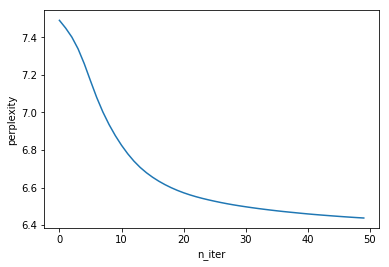

In [334]:
T = 10
phi, theta = train(T)

In [335]:
for t in range(T):
    print(t, list(map(lambda i: names[i], np.argpartition(phi[:, t], -n)[-n:])))

0 ['sunday', 'draft', 'hillary', 'hrod17clintonemailcom', 'thank', 'message', 'let', 'send', 'please', 'best', 'monday', 'tomorrow', 'yes', 're', 'thanks', 'b6', 'email', 'below', 'cdm', 'haiti']
1 ['world', 'media', 'valmoro', 'washington', 'european', 'international', 'administration', 'china', 'issues', 'military', 'special', 'press', '202', 'national', 'strategic', 'nuclear', 'officials', 'diplomacy', 'assistant', 'iran']
2 ['wjc', 'f201504841', '05132015', 'un', 'libya', 'foia', 'redactions', 'waiver', 'select', 'produced', 'doc', 'subject', 'case', 'dept', 'agreement', 'information', 'comm', 'sensitive', 'benghazi', 'date']
3 ['arab', 'times', 'against', 'palestinian', 'leader', 'labour', 'minister', 'deal', 'republican', 'vote', 'election', 'netanyahu', 'between', 'israel', 'senate', 'israeli', 'jewish', 'party', 'peace', 'democrats']
4 ['holbrooke', 'taliban', 'war', 'millscdstategov', 'mills', 'general', 'fw', 'mcchrystal', 'afghan', 'afghanistan', 'abedin', 'military', 'huma'

A Jupyter Widget

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


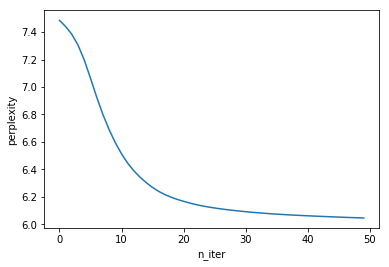

In [336]:
T = 20
phi, theta = train(T)

In [337]:
for t in range(T):
    print(t, list(map(lambda i: names[i], np.argpartition(phi[:, t], -n)[-n:])))

0 ['dinner', 'best', 'getting', 'tomorrow', 'check', 'forward', 'add', 'sure', 'sorry', 'im', 'ill', 'message', 'email', 'id', 'pls', 'haiti', 'list', 'hope', 'thx', 'happy']
1 ['because', 'senators', 'democrats', 'former', 'another', 'chief', 'bill', 'republican', 'white', 'republicans', 'clintons', 'washington', 'staff', 'administration', 'vote', 'hillary', 'obamas', 'say', 'senate', 'senator']
2 ['troops', 'white', 'minister', 'general', 'justice', 'afghanistan', 'party', 'uup', 'mcchrystal', 'deal', 'agreement', 'robinson', 'vote', 'says', 'official', 'northern', 'cameron', 'military', 'war', 'ireland']
3 ['federal', 'public', 'voters', 'during', 'national', 'democrats', 'group', 'obamas', 'right', 'beck', 'republicans', 'movement', 'democratic', 'campaign', 'john', 'tea', 'republican', 'boehner', 'party', 'conservative']
4 ['10', 'eu', 'discussed', 'others', 'go', 'speech', 'week', 'trip', 'meet', 'going', 'next', 'issues', 'discuss', 'morning', 'draft', 'issue', 'come', 'still', 

С ростом числа тем в них появляются общие слова (например, `too`, `year`, `too`, `where`, `then`, etc), поэтому конкретность  снижается

A Jupyter Widget

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


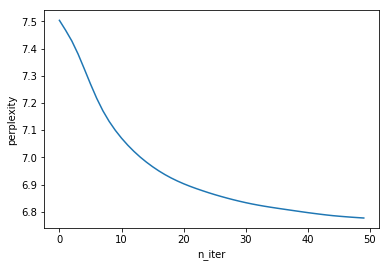

In [338]:
T = 5
phi, theta = train(T)

In [339]:
for t in range(T):
    print(t, list(map(lambda i: names[i], np.argpartition(phi[:, t], -n)[-n:])))

0 ['email', 'thursday', 'saturday', 'sunday', 'im', 'cheryl', 'mills', 'thx', 'tomorrow', 'monday', 'pls', 'huma', 'b6', 'hrod17clintonemailcom', 'sent', 'fw', 'friday', 're', 'abedin', 'print']
1 ['working', 'thank', 'world', 'f201504841', '05132015', 'foia', 'redactions', 'select', 'date', 'doc', 'produced', 'comm', 'case', 'information', 'benghazi', 'sensitive', 'waiver', 'dept', 'subject', 'agreement']
2 ['among', 'while', 'national', 'afghan', 'mcchrystal', 'republican', 'americans', 'former', 'voters', 'obamas', 'general', 'against', 'party', 'military', 'war', 'david', 'afghanistan', 'election', 'ok', 'percent']
3 ['nuclear', 'east', 'washington', 'diplomacy', 'conference', 'international', 'residence', 'daily', 'israel', 'israeli', 'peace', 'depart', 'route', 'minister', 'private', 'staff', 'arrive', 'national', 'un', 'en']
4 ['take', 'says', 'health', 'too', 'go', 'china', 'years', 'year', 'going', 'senate', 'women', 'then', 'make', 'bill', 'because', 'even', 'many', 'much', '

A Jupyter Widget

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


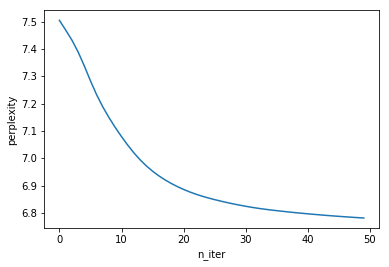

In [340]:
phi, theta = train(T)

In [341]:
for t in range(T):
    print(t, list(map(lambda i: names[i], np.argpartition(phi[:, t], -n)[-n:])))

0 ['reform', 'bill', 'care', 'health', 'voters', 'election', 'democrats', 'democratic', 'former', 'vote', 'campaign', 'congress', 'americans', 'republicans', 'percent', 'white', 'obamas', 'republican', 'senate', 'party']
1 ['here', 'hope', 'week', 'thanks', 'next', 'go', 'great', 'afghan', 'working', 'way', 'best', 'dont', 'make', 'thx', 'im', 'going', 'let', 'afghanistan', 'tomorrow', 'much']
2 ['floor', 'minister', 'white', 'washington', 'release', 'route', 'arrive', 'conference', 'talk', 'residence', 'daily', 'depart', 'fm', 'email', 'b6', 'private', 'en', 'airport', 'staff', 'press']
3 ['comm', 'where', 'because', 'economic', 'doc', 'dept', 'select', 'produced', 'case', 'china', 'many', 'benghazi', 'date', 'world', 'subject', 'information', 'agreement', 'women', 'international', 'sensitive']
4 ['david', 'mcchrystal', 'ok', 'huma', 'saturday', 'sid', 'friday', 'abedin', 'mills', 'sunday', 'iran', 'minister', 'cheryl', 'peace', 'wednesday', 'hrod17clintonemailcom', 'israeli', 're', '

При нескольких запусках с разными начальными приближениями темы могут меняться местами, но набор слов в темах остается схожий 

### Модель LDA и визуализация

Модель [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) является наиболее популярной тематической моделью. Единственное отличие от модели PLSA заключается в введении априорных распределений Дирихле на столбцы матриц $\Phi$ и $\Theta$, которое может способствовать дополнительному сглаживанию или разреживанию параметров.

В этом задании предлагается воспользоваться [стандартной реализацией LDA в sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и реализацией модели [LdaModel в gensim](https://radimrehurek.com/gensim/models/ldamodel.html), обучение которых основано на вариационном байесовском выводе.

Выполнение задания потребует установки пакета [gensim](https://radimrehurek.com/gensim/install.html).

Подготовьте данные в формате, подходящем для *gensim* (полное [API](https://radimrehurek.com/gensim/apiref.html) gensim). [Пример обработки вывода](https://gist.github.com/aronwc/8248457) *CountVectorizer* для gensim.

**Задание 7. (1.5 балла)** Примените [LdaModel gensim](https://radimrehurek.com/gensim/models/ldamodel.html) к подготовленным данным (рекомендуется задать заведомо большое число итераций в параметре *passes*, например, 30). 
Примените [LdaModel sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation). Необходимо задать *learning_method='online'*. Основными настраиваемыми параметрами являются *learning_decay*, *max_iter* и *batch_size*.  Рекомендуется настроить алгоритм по сетке параметров, например, оптимизируя перплексию (кстати, у класса *sklearn.decomposition.LatentDirichletAllocation* есть метод *perplexity*).  Для простоты допускается зафиксировать параметр *learning_decay* в промежутке $(0.5; 1)$, зафиксировать параметр max_iter в промежутке $[30; 60]$ и перебрать несколько значений параметра *batch_size* по логарифмической шкале (например, степени двойки).

Визуально сравните полученные темы по топ-20 наиболее вероятным словам у обоих алгоритмов между собой и с темами, полученными выше вашей реализацией ЕМ-алгоритма (нерегуляризованного). Какая из моделей даёт более интерпретируемые темы и почему?